# 05-1 결정 트리

### 로지스틱 회귀로 와인 분류하기
- 이 데이터셋은 캐글의 Red Wine Quality 데이터셋의 일부를 발췌한 것입니다.
- http://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
- https://bit.ly/wine_csv_data

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
wine.head() # 알코올 도수, 당도, PH, class(0: 레드 와인, 1: 화이트 와인)

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
# 누락된 값이 없고 모두 실수형인것을 확인
# 누락값이 있다면 그 데이터를 버리거나 평균값으로 채운후 사용
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [4]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [5]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split
# 기본적으로 25%를 데스트로 지정함
train_input, test_input, train_target, test_target=train_test_split(data, target, test_size = 0.2, random_state=42)

In [7]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))
# 생각보다 점수가 높지가 않다.
# 과소적합했따고 판단
# C값이나 solver 등 매개변수를 바꿔봐야겠네?..

0.7808350971714451
0.7776923076923077


#### 설명하기 쉬운 모델과 어려운 모델

In [10]:
print(lr.coef_ , lr.intercept_)
# 일반인들이 볼떈 이 계수들의 어떻게 산출되었는지 정확한 의미를 잘 모른다.
# 순서도가 있으면 좋겠다?ㅎㅎ

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


### 결정 트리
- 결정 트리 모델은 분류 규칙(이유)를 설명하기 쉽다
- 예/아니오에 대한 질문을 이어나가면서 정답을 찾아 학습하는 알고리즘이다. 비교적 예측 과정을 이해하기 쉽고 성능도 뛰어난다.

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 로지스틱에 비해 훈련 점수가 엄청 높게 나온다.
# 하지만 과대적합이 된것을 확인!!!...

0.996921300750433
0.8592307692307692


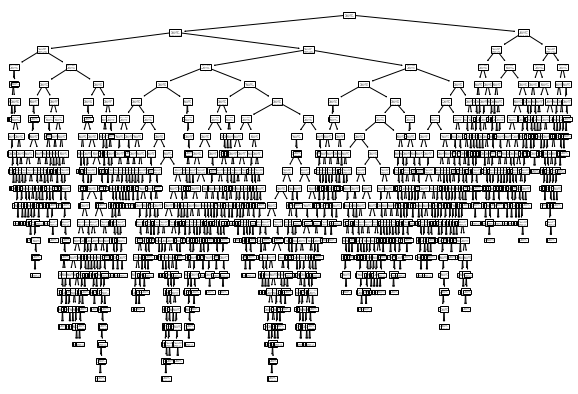

In [12]:
# 결정트리를 시각화해보자
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize = (10, 7))
plot_tree(dt)
plt.show()
# 맨 위를 루트노드라고 한다.
# 맨 밑을 리프 노드라고 한다.
# 루트노드는 하나지만 리프 노드는 여러개이다

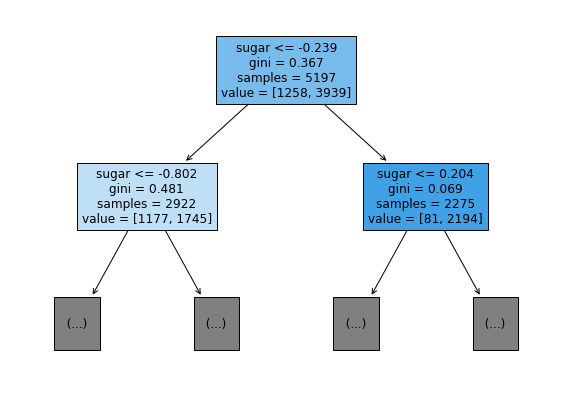

In [13]:
plt.figure(figsize = (10, 7))
# filled = True 로 지정하면 클래스마다 색깔을 부여하고, 어떤 클래스의 비율이 높아지면 점점 진한 색으로 표시한다.
plot_tree(dt, max_depth = 1, filled =True, feature_names = ['alcohol', 'sugar', 'pH'])
# max_depth는 가지라고 생각하면 좋다
plt.show()
# value = [음성(레드 와인), 양성(화이트 와인)]
# 만약 이 결정 트리의 성장을 여기서 멈춘다면 왼쪽 노드와 오른쪽 모드 양성 클래스로 예측된다. 두 노드 양성 클래스가 많아서
# 만약 결정 트리를 회귀 문제에 적용하면 리프 노드에 도달한 샘플의 타깃의 평균값으로 예측값을 사용함 DecisionTreeRegressor

#### 불순도
- gini는 지니 불순도(Gini impurity)를 의미한다.
- DecisionTreeClassifier 클래스의 criterion매개변수의 기본값은 gini다.

$$지니 불순도 = 1 - (음성 클래스 비율^{2} + 양성 클래스 비율^{2})$$

- 노드에 하나의 클래스만 있다면 지니 불순도는 0이 되어 가장 작고 이 노드를 순수 노드라고 부른다
- 결정 트리 모델은 부모 노드(parent node)와 자식 노드(child node)의 불순도 차이가 가능한 크도록 트리를 성장시킨다.

$$불순도의 차이 = 부모의 불순도 - (왼쪽 노드 샘플 수 / 부모의 샘플 수) * 왼쪽 노드 불순도 - (오른쪽 노드 샘플 수 / 부모의 샘플 수) * 오른쪽 노드 불순도$$

- 부모와 자식 노드 사이의 불순도 차이를 정보 이득(information gain)이라고 한다.

- DecisionTreeClassifier 클래스에서 criterion = 'entropy'를 지정하여 엔트로피 불순도를 사용할 수 있다.

$$엔트로피 불순도 = -음성 클래스 비율 * log_{2}(음성 클래스 비율) - 양성 클래스 비율 * log_{2}(양성 클래스 비율)$$

- 보통 기본값인 지니 불순도와 엔트로피 불순도가 만든 결과의 차이는 크지 않다.

#### 가지치기
- 트리가 무작정 끝까지 자라나는 트리는 훈련 세트에는 아주 잘 맞겠지만 테스트 세트에서 점수는 그에 못 미친다.
- max_depth를 통해 가지치기를 해서 과대적합을 해소해보자!

In [14]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 이전 full tree보다 훈련 세트의 성능은 낮아졌지만 테스트 세트의 성능은 거의 그대로 하지만 과대적합 해소

0.8454877814123533
0.8415384615384616


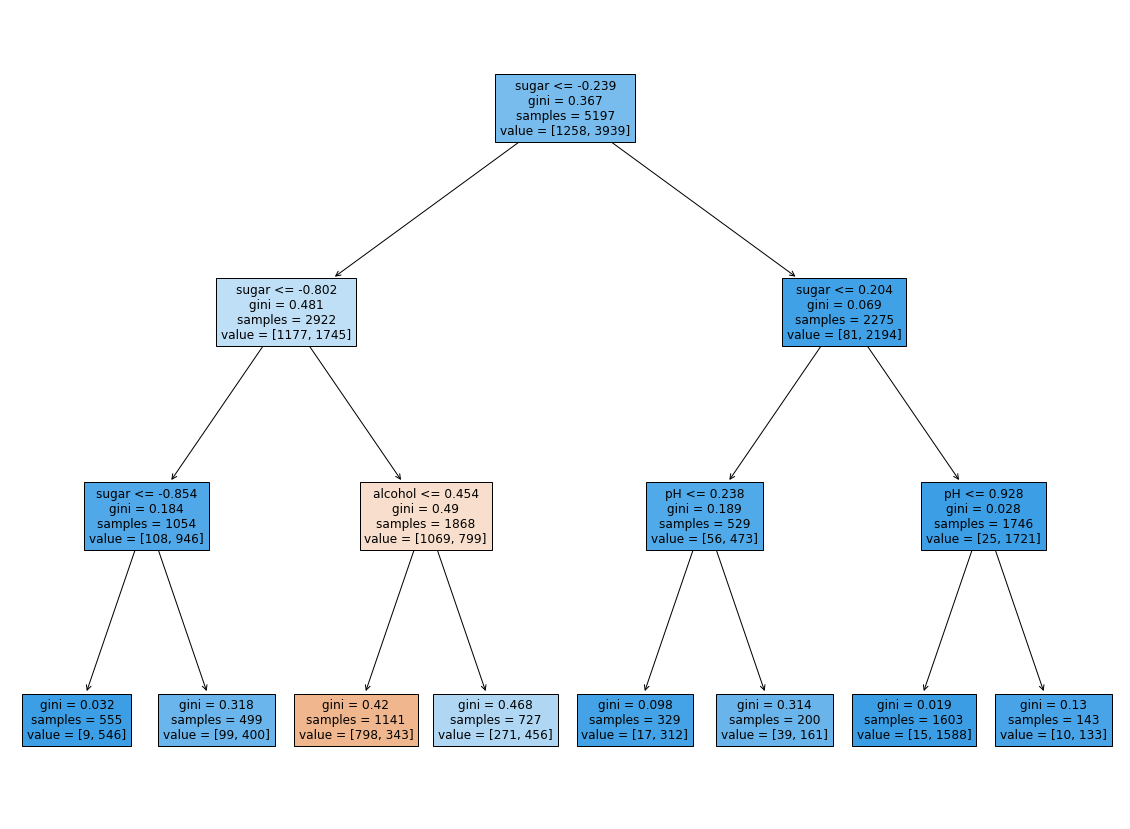

In [15]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()
# 레드와인이라고 분류하려면 당도가 -0.239보다 작고 또 -0.802 보다 커야한다. 그리고 알코올 도수는 0.454보다 작아야 한다.

In [16]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))
# 전처리 하기전이랑 후랑 결과가 같음 
# 결론 트리는 전처리 하지말자

0.8454877814123533
0.8415384615384616


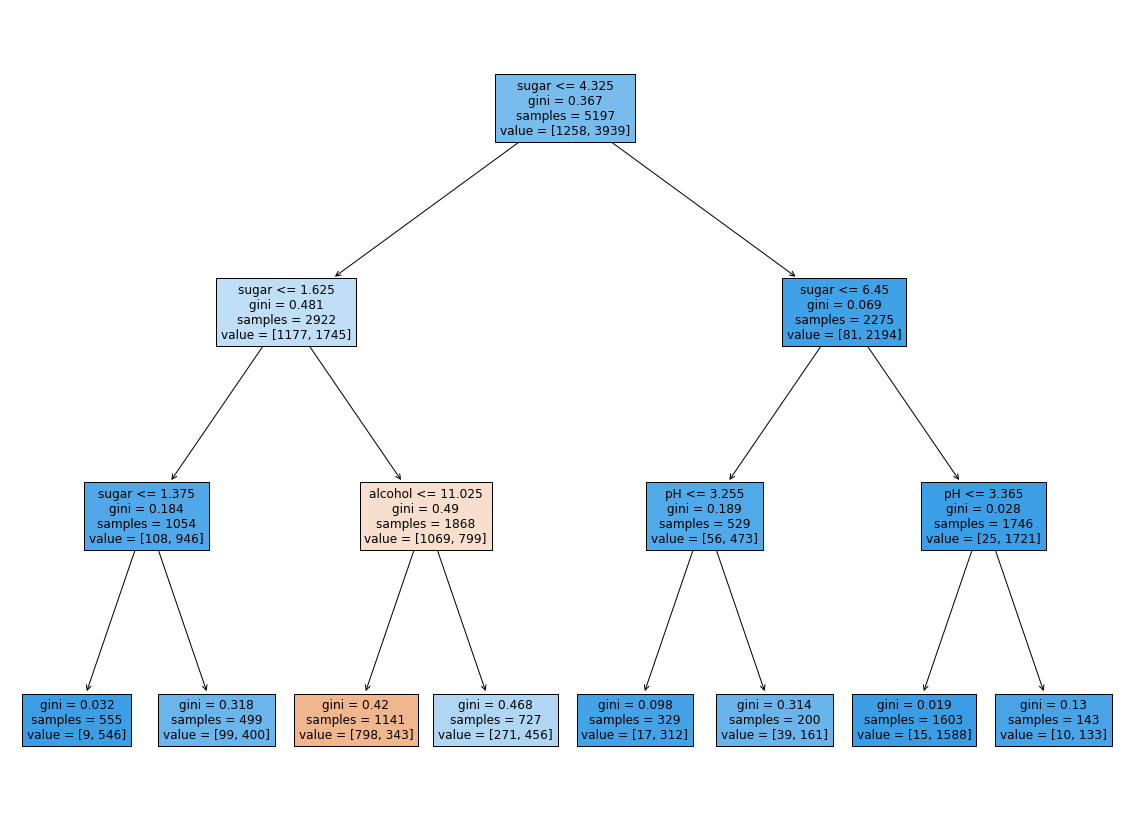

In [17]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()
# 1.625 < 당도 <= 4.325 이고 알코올 도수가 11.025와 같거나 작은 것이 레드와인이다.
# 표준점수로 바꾸지 않아 이해가 쉽다.

In [18]:
# feature importance 
# 특성 중요도는 결정 트리에 사용된 특성이 불순도를 감소하는데 기여한 정도를 나태내는 값이다.
# 'alcohol', 'sugar', 'pH'
# 순서는 데이터 입력 순
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


0.8874350586877044
0.8615384615384616


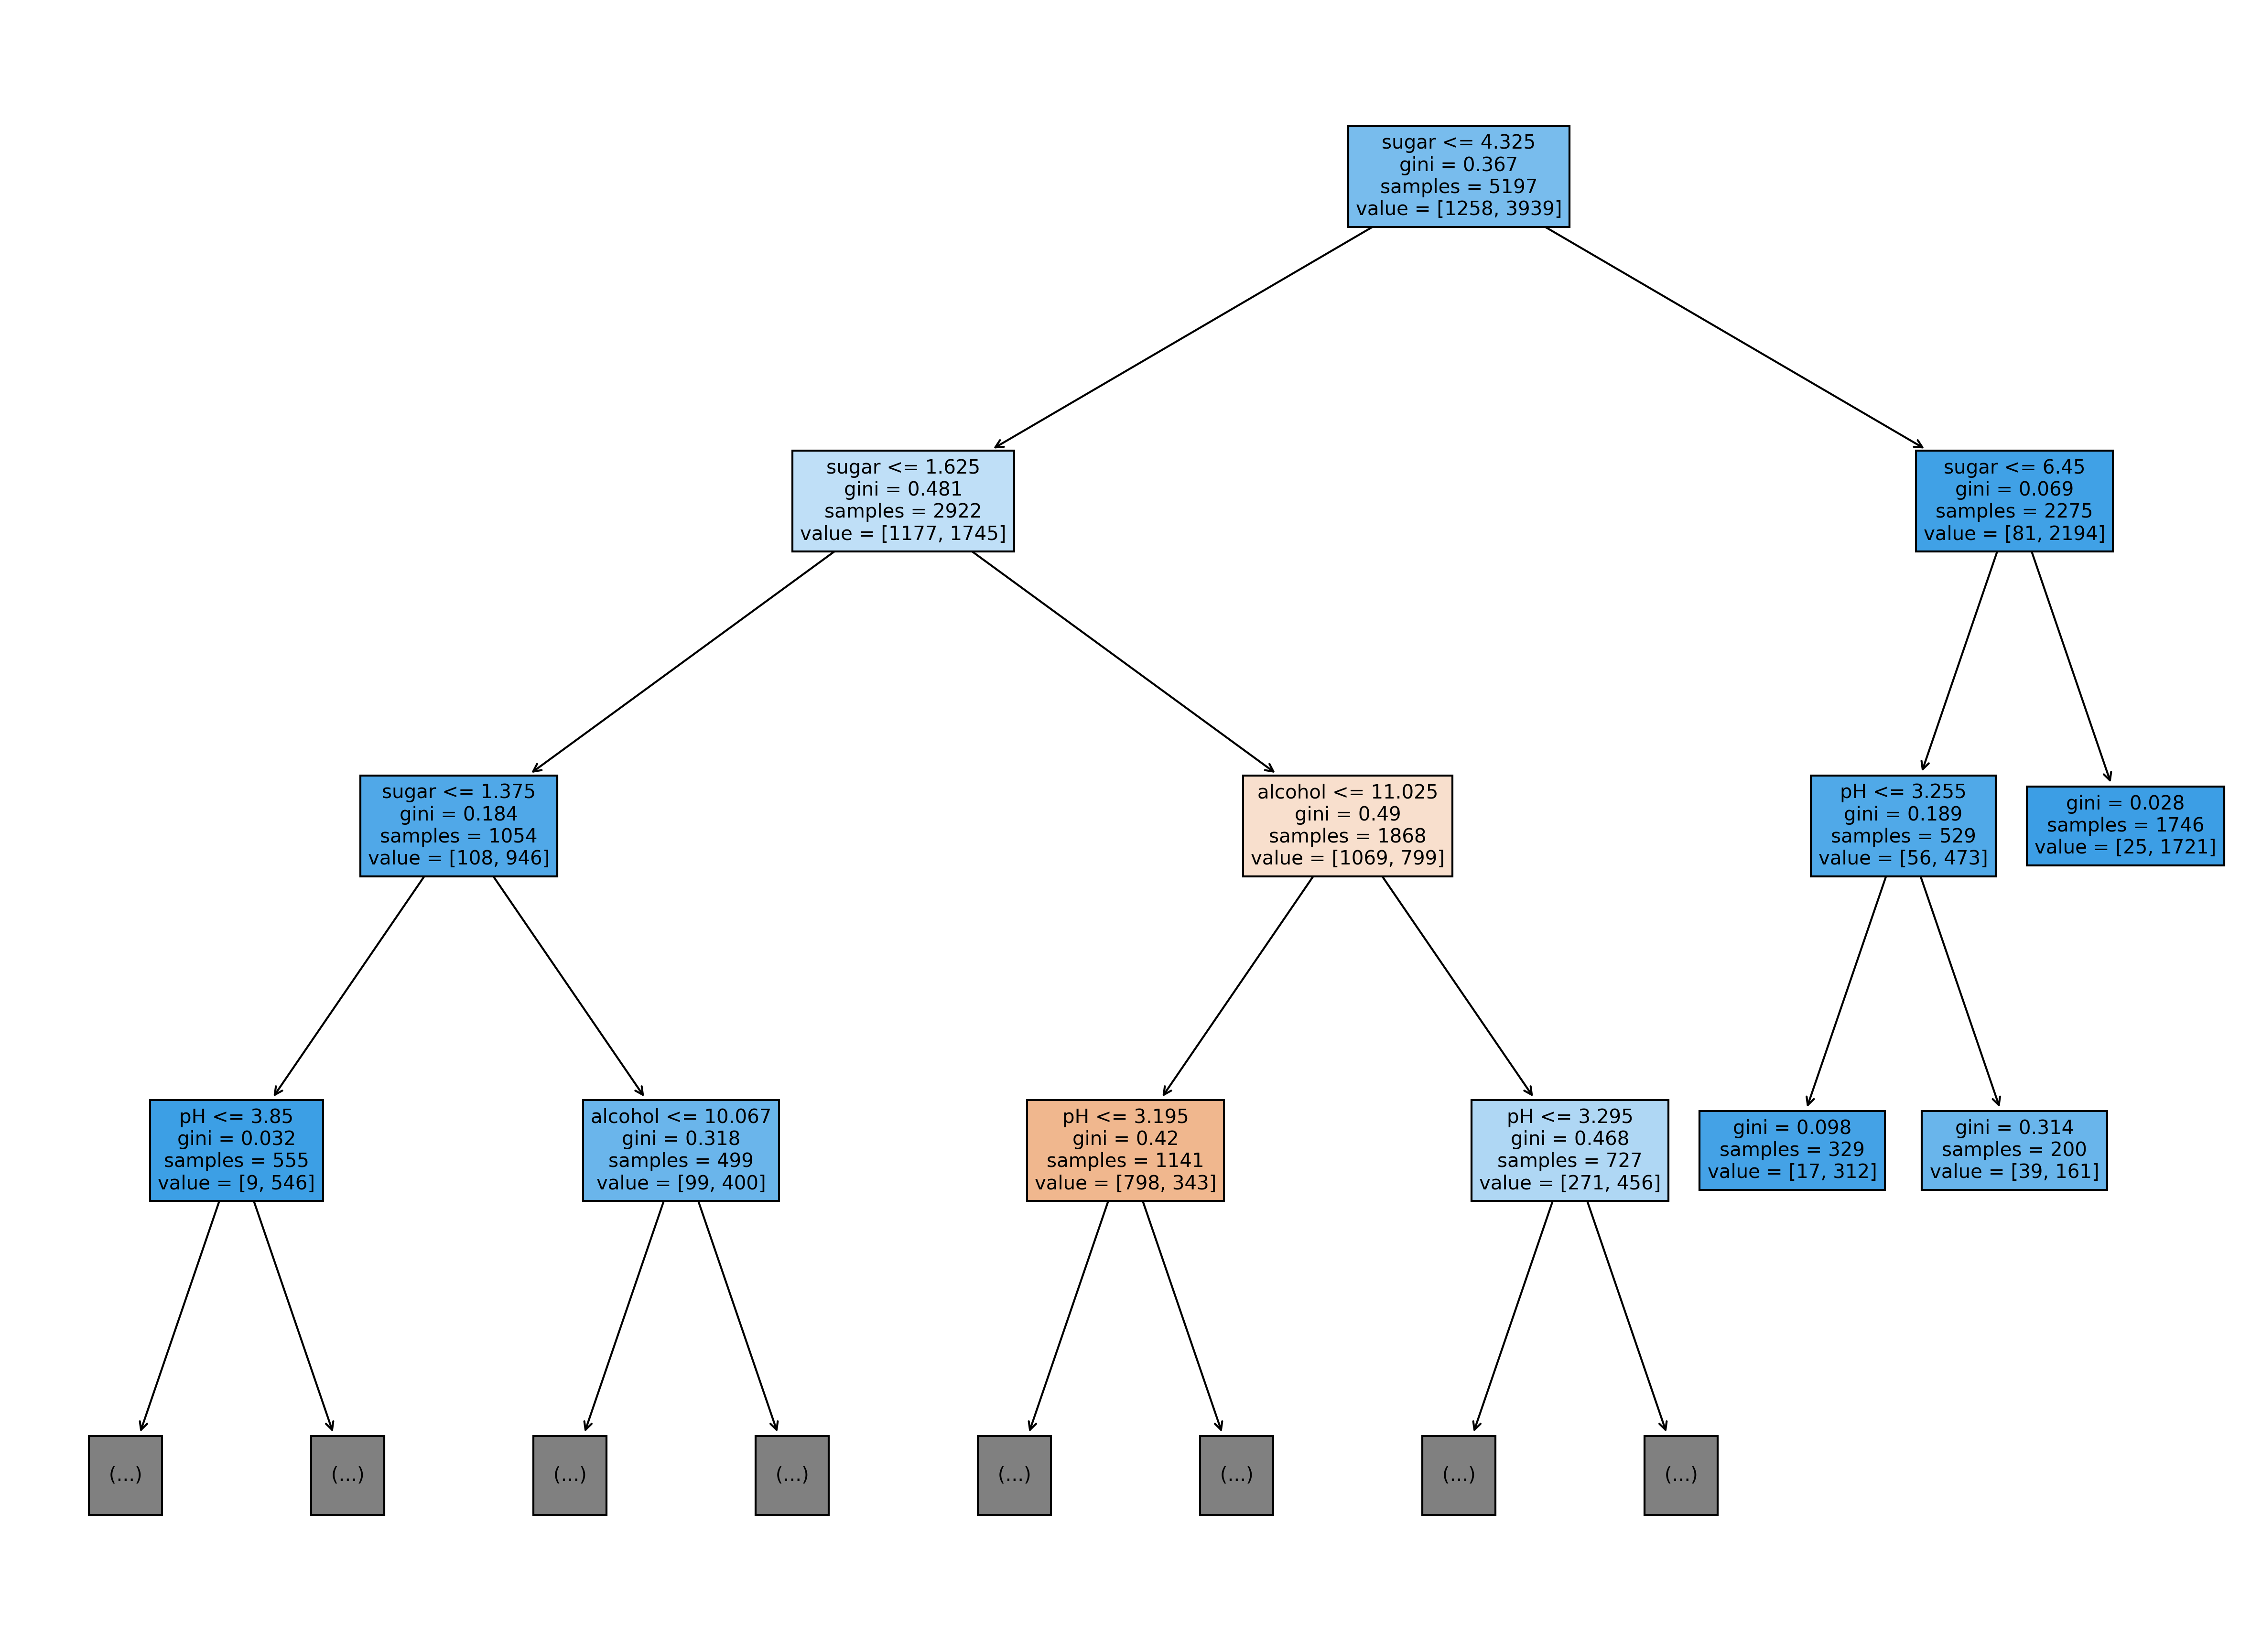

In [19]:
# 가지치기를 max_depth로 할수 있지만 min_impurity_decrease를 통해서도 가능하다.
# min_impurity_decrease 값이 클수록 가지치기를 더많이 한다고 생각하면 좋을듯? ㅎㅎ
dt = DecisionTreeClassifier(min_impurity_decrease = 0.0005, random_state = 42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))
plt.figure(figsize = (20, 15), dpi = 300)
plot_tree(dt, max_depth = 3,filled =True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

### 핵심 패키지와 함수
#### pandas
- info()는 데이터프레임의 요약된 정보를 출력한다. 인덱스와 컬럼 타입을 출력하고 null이 아닌 값의 개수, 메모리 사용량을 제공한다.
    - verbose 매개변수의 기본값은 True를 False로 바꾸면 각 열에 대한 정보를 출력하지 않는다.
- describe()는 데이터프레임 열의 통계 값을 제공한다. 수치형일 경우 최소, 최대, 평균, 표준편차와 사분위값 등이 출력된다.
    - percentiles 매개변수는 백분위수를 지정한다. 기본값은 [0.25, 0.5, 0.75] 이다.

#### scikit-learn
- DecisionTreeCassifier는 결정 트리 분류 클래스다.
    - crierion 매개변수는 불순도를 지정하며 기본값은 'gini'고 'entropy'도 있다.
    - splitter 매개변수는 노드를 분할하는 전략을 선택한다. 기본값은 'best'로 정보 이득이 최대가 되도록 분할하고, 'random'이면 임의로 노드를 분할한다.
    - max_depth 매개변수는 트리가 성장할 최대 깊이를 지정한다. 기본값은 'None'으로 리프 노드가 순수하거나 min_samples_split보다 샘플 개수가 적을 때까지 성장한다.
    - min_sample_split은 노드를 나누기 위한 최소 샘플 개수이며 기본값은 2다.
    - max_features 매개변수는 최적의 분항을 위해 탐색할 특성의 개수를 지정한다. 기본값은 None으로 모든 특성을 사용한다.
- plot_tree()는 결정 트리 모델을 시각화한다. 첫 번째 매개변수로 결정 트리 모델 객체를 전달한다.
    - max_depth 매개변수는 나타낼 트리의 깊이를 지정한다. 기본값은 None으로 모든 노드를 출력한다.
    - feature_names 매개변수는 특성의 이름을 지정한다.
    - filled 매개변수는 True로 지정하면 타깃값에 따라 노드 안에 색을 채운다.

# 05-2 교차 검증과 그리드 서치

### 검증 세트
- 테스트 세트를 사용하지 않으면 모델이 과적합인지 판단하기 어려운데 테스트 세트를 사용하지 않고 이를 측정하는 간단한 방법을 검증 세트(validation set)라고 부른다.
- 일반적으로, 훈련세트(약 60%), 검증세트(20%), 테스트세트(약20%)로 나뉜다.

In [20]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [21]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [22]:
# train , test 셋 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)

In [23]:
# train 셋을 train + validation set으로 나누기
from sklearn.model_selection import train_test_split
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [24]:
print(sub_input.shape, val_input.shape, test_input.shape)

(4157, 3) (1040, 3) (1300, 3)


In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))
# 과대적합이네

0.9971133028626413
0.864423076923077


### 교차 검증
- 교차 검증은 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복한다. 그 다음 이 점수를 평균하여 최종 검증 점수를 얻는다.
- 3-폴드 교차 검증는 훈련 세트를 세 부분으로 나눠서 교차 검증을 수행하는 것을 3-폴드 교차 검증리아고 한다.
- 통칭 k-폴드 교차 검증(k-fold cross validation)이라고 한다.
- 보통 5-폴드 교차 검증이나 10-폴드 교차 검증을 많이 사용한다.

In [26]:
# 따로 train_test_split으로 validation set을 떼어 내지 않는다.
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)
# cross_validate 함수는 기본으로 5-폴드 교차 검증을 수행한다. cv 매개변수에서 폴드 수를 바꿀 수도 있다.

{'fit_time': array([0.01595736, 0.01496077, 0.01395679, 0.00997186, 0.00698066]), 'score_time': array([0.00099802, 0.00099754, 0.00099874, 0.        , 0.00099802]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [27]:
import numpy as np
print(np.mean(scores['test_score'])) # 5개의 점수를 평균

0.855300214703487


In [28]:
# KFold
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle = True, random_state = 42)

In [29]:
# cross_validate()함수는 기본적으로 회귀 모델일 경우 KFold분할기를 사용하고,
# 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용한다.
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [30]:
# 분류 문제가 아닌 회귀에서는 cv에서 fold 수를 입력해주면 되는데
# 분류 문제에서는 아래와 같이 사용 -> 타깃 클래스를 골고루 나누기 위해
splitter = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하이퍼파라미터 튜닝
- 머신러닝 모델이 학습하는 파라미터를 모델 파라미터라고 부르고 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터를 하이퍼파라미터라고 한다.
- 그리드 서치(Grid Search)는 하이퍼파라미터 탐색을 자동화해 주는 도구이다.
- 사이킷런의 GrideSearchCV 클래스는 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행해서 cross_validate() 함수를 호출할 필요가 없다.

In [31]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001,0.0002,0.0003,0.0004,0.0005]}
# 0.0001부터 0.0005까지 0.0001씩 증가하는 5개의 값을 시도

In [32]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42),params, n_jobs=-1)
# n_jobs=-1 은 성능 향상에 좋음

In [33]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [34]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [35]:
# best parameter 확인
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [36]:
# 5번의 교차 검증으로 얻은 점수 출력
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [37]:
# np.argmax -> 가장 큰 값을 가지는 위치 인덱스를 산출
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [38]:
# 여러개 파라미터로 해보기
# 결국 파라미터 범위는 이용자가 정해야하는데 어떻게 하나????
# 간격 기준을 0.0001 혹은 1 혹은 10으로 했는데... 근거는?? 없다
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
         'max_depth' : range(5, 20, 1),
         'min_samples_split' : range(2, 100, 10)
         }

In [39]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs =-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [40]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [41]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


#### 랜덤 서치
- 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있다. 이럴 때 랜덤 서치(Random Search)를 사용한다.

In [42]:
from scipy.stats import uniform, randint
# ufigorm 은 균등 분포에서 샘플링한다.(실수값)
# randint는 정수값을 뽑는다.

In [43]:
rgen = randint(0, 10)
rgen.rvs(10)

array([4, 2, 6, 1, 2, 7, 4, 1, 5, 1])

In [44]:
np.unique(rgen.rvs(1000), return_counts = True) # return_counts 는 각각 뽑힌 횟수를

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([106, 108,  97,  84,  94, 113,  90,  94, 119,  95], dtype=int64))

In [45]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.69529283, 0.05558482, 0.7850222 , 0.27523735, 0.15960543,
       0.68631679, 0.77906457, 0.93657262, 0.36116875, 0.3871645 ])

In [46]:
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
         'max_depth' : randint(20, 50),
         'min_samples_split' : randint(2, 25),
         'min_samples_leaf' : randint(1, 25),
         }

In [47]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), params,
                       n_iter = 100, n_jobs = -1, random_state = 42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020ACA6A5910>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020ACA6A5430>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020ACA6A5130>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020ACA6A52E0>},
                   random_state=42)

In [48]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [49]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [50]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))
# 과적합은 없고 어느정도 성능도 나오네...

0.86


### 핵심 패키지와 함수
#### scikit-learn
- cross_validaate()는 교차 검증을 수행하는 함수다.
    - 첫 번째 매개변수는 교차 검증에 수행할 모델 객체를 전달한다.
    - 두 번째, 세 번째 매개변수에 특성과 타깃 데이터를 전달한다.
    - scoring 매개변수는 검증에 사용할 평가 지표를 지정한다. 기본적으로 분류 모델은 정확도를 의미하는 'accuracy', 회귀 모델은 결정계수를 의미하는 'r2'가 된다.
    - cv 매개변수는 교차 검증 폴더 수나 스플리터 객체를 지정한다. 기본값은 5이며 회귀일 때는 'KFold'클래스를 사용하고 분류일 때는 StratiedKFold 클래스를 사용하여 5-폴드 교차 검증을 수행한다.
    - n_jobs 매개변수는 -1로 지정한다.
    - return_train_score 매개변수는 True로 지정하면 훈련 세트의 점수를 반환다. 기본값은 False다.
    
- GridSearchCV는 교차 검증으로 하이퍼파라미터 탐색을 수행한다. 
    - 첫 번째 매개변수로 그리드 서치를 수행할 모델 객체를 전달한다.
    - 두 번째 매개변수에는 탐색할 모델의 매개변수와 값을 전달한다.
    - scoring, cv, n_jobs, return_train_score 매개변수는 cross_validate()함수와 동일
    
- RandomizedSearchCV는 교차 검증으로 랜덤한 하이퍼파라미터 탐색을 수행한다.
    - 첫 번째 매개변수로 그리드 서치를 수행할 모델 객체를 전달한다. 
    - 두 번째 매개변수에는 탐색할 모델의 매개변수와 확률 분포 객체를 전달한다.
    - scoring, cv, n_jobs, return_train_score 매개변수는 cross_validate()함수와 동일

# 05-3 트리의 앙상블
- 앙상블 학습은 더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 머신러닝 알고리즘을 말한다.

### 정형 데이터와 비정형 데이터
- 정형 데이터(structured data)는 어떤 구조로 되어 있다는 뜻으로 CSV나 데이터베이스(Database), 혹은 엑셀(Excel)에 저장하기 쉽다.
- 비정형 데이터(unstructured data)는 데이터 베이스나 엑셀로 표현하기 어려운 것으로 책의 글과 같은 텍스트 데이터, 디지털카메라로 찍은 사진, 핸드폰으로 듣는 디지털 음악 등이 있다.
- 앙상블 학습(ensemble learning)은 정형 데이터를 다루는 데 가장 뛰어난 성과를 낸다. 이 알고리즘은 결정 트리를 기반으로 만들어졌다.

### 랜덤 포레스트
- 랜덤 포레스트(Random Forest)는 앙상블 학습의 대표 주자 중 하나로 안정적인 성능 덕분에 널리 사용되고 있다. 
- 랜덤 포레스트는 각 트리를 훈련하기 위한 데이터를 랜덤하게 만든다. 우리가 입력한 훈련 데이터에서 랜덤하게 샘플을 추출하여 훈련 데이터를 만든다. 이때 한 샘플이 중복되어 추출될 수 있다. 이렇게 만들어진 샘플을 부트스트랩 샘플(bootstap sample)이라고 부른다.
- 부트스트랩 샘플은 훈련 세트와 크기가 같다.
- 또한 각 노드를 분할할 때 전체 특성 중에서 일부 특성을 무작위로 고른 다음 이 중에서 최선의 분할을 찾는다. 분류 모델인 RandomForestClassifier은 기본적으로 전체 특성 개수의 제곱근만큼의 특성을 선택한다. 회귀 모델인 RandomForestRegressor은 전체 특성을 사용한다.
- 사이킷런의 랜덤 포레스트는 기본적으로 100개의 결정 트리를 위 방식으로 훈련한다. 그 다음 분류일 때는 각 트리의 클래스별 확률을 평균하여 가장 높은 확률을 가진 클래스를 예측으로 삼는다. 회귀일 때는 단순히 각 트리의 예측을 평균한다.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
wine = pd.read_csv('https://bit.ly/wine_csv_data')
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state= 42)

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state= 42)

In [3]:
scores = cross_validate(rf, train_input, train_target,
                       return_train_score = True, n_jobs = -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 과대적합이다. -> 하이퍼파라미터 튜닝해야하지만 알고리즘을 알아보는게 목적이어서 PASS!!
# 랜덤 포레스트는 경정 트리의 앙상블이기 때문에 DecisionTreeClassifier가 제공하는 중요한 매개변수를 모두 제공한다. 
# criterion, max_depth, max_features, min_samples_split, min_impurity_decrease, min_sample_leaf 등

0.9973541965122431 0.8905151032797809


In [4]:
# 중요 특성도 결정트리와 동일하게 중요하다고 말해준다.
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


In [5]:
# 랜덤 포레스트는 훈련 세트에서 중복을 허용하여 부트스트랩 샘플을 만들어 결정 트리를 훈련한다. 
# 이때 부트스트랩 샘플에 포함되지 않고 남는 샘플이 있는데 이런 샘플을 OOB(out ot bag)샘플이라고 한다.
# 이 남는 샘플을 사용하여 부트스트랩 샘플로 훈련한 결정 트리를 평가할수 있다. 
# oob_score = True 를 하면 됨
rf = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state= 42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


### 엑스트라 트리
- 엑스트라 트리(Extra Trees)는 랜덤 포레스트와 매우 비슷하게 동작한다. 기본적으로 100개의 결정 트리를 훈련한다.
- 랜덤 포레스트와 엑스트라 트리의 차이점은 부트스트랩 샘플을 사용하지 않는다는 점이다. 즉 각 결정 트리를 만들 때 전체 훈련 세트를 사용한다. 대신 가장 좋은 분할을 찾는 것이 아니라 무작위로 분할한다. 
- 무작위로 분할한다면 성능이 낮아지겠지만 많은 트리를 앙상블 하기 때문에 과대적합을 막고 검증 세트의 점수를 높이는 효과가 있다. 

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target,
                        return_train_score=True, n_jobs = -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 랜덤 포레스트와 비슷한 결과를 얻었다. 이 예제는 특성이 많지 않아 두 모델의 차이가 크지 않다.
# 보통 엑스트라 트리가 무작위성이 좀 더 크기 때문에 랜덤 포레스트보다 더 많은 결정 트리를 훈련해야한다.
# 하지만 랜덤하게 노드를 분할하기 때문에 빠른 계산 속도가 엑스트라 트리의 장점이다.

0.9974503966084433 0.8887848893166506


In [7]:
et.fit(train_input, train_target)
print(et.feature_importances_)
# 득성 중요도 랜덤 포레스트와 동일하게 나온다.

[0.20183568 0.52242907 0.27573525]


### 그레이디언트 부스팅

- 랜덤 포레스트나 엑스트라 트리와 달리 결정 트리를 연속적으로 추가하여 손실 함수를 최소화하는 앙상블 방법이다.
- 그레이디언트 부스팅(gradient boosting)은 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블 하는 방법이다.
- 사이킷런의 GradientBoostingClassifier는 기본적으로 깊이가 3인 결정 트리를 100개 사용한다.깊이가 얕은 결정 트리를 사용하기 때문에 과대적합에 강하고 일반적으로 높은 일반화 성능을 기대한다.
- 그레이디언트란 경사 하강법을 사용하여 트리를 앙상블에 추가한다. 분류에서는 로지스트기 손실 함수를 사용하고 회귀에서는 평균 제곱 오차 함수를 사용한다.
- 가장 낮은 곳을 찾아 내려오는 방법은 모델의 가중치와 절편을 조금씩 바꾸는 것이다. 그레이디언트 부스팅은 결정 트리를 계속 추가하면서 가장 낮은 곳을 찾아 이동한다.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target,
                       return_train_score = True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 과대적합이 되지 않는다. 

0.8881086892152563 0.8720430147331015


In [10]:
# 트리의 개수와 학습률을 조절해보자
# learning_rate의 기본값은 0.1이다.
# 학습률 매개변수가 크면 복잡하고 훈련 세트에 과대적합된 모델을 얻을 수 있다.
gb = GradientBoostingClassifier(n_estimators= 500, learning_rate = 0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target,
                       return_train_score = True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 기본값으로 돌렸을때보다 성능이 좋아지긴하였으나 약간의 과적합이 있어보인다.

0.9464595437171814 0.8780082549788999


In [12]:
# 그레이디언트 부스팅은 랜덤 포레스트보다 일부 특성을 더 집중한다.
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15872278 0.68011572 0.16116151]


In [13]:
# 일반적으로 그레이디언트 부스팅이 랜덤 포레스트보다 조금 더 높은 성능을 얻을 수 있다.
# 하지만 순서대로 트리를 추가하기 때문에 훈련 속도가 느리다.
# 즉 GradientBoostingClassifier에는 n_jobs 매개변수가 없다. 회귀버전은 GradientBoostingRegressor이다.

### 히스토그램 기반 그레이디언트 부스팅
- 히스토그램 기반 그레이디언트 부스팅(Histogram-based Gradient Boosting)은 그레이디언트 부스팅의 속도를 개선한 것이며 입력 특성을 256개의 구간으로 나눈다. 따라서 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있다.
- 256개의 구간 중에서 하나를 떼어 놓고 누락된 값을 위해 사용한다. 따라서 입력에 누락된 특성이 있더라도 이를 따로 전처리할 필요가 없다.

In [15]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
# HistGradientBoostingClassifier에는 트리의 개수를 지정하는데 n_estimators 대신에 부스팅 반복 횟수를 지정하는 max_iter를 사용한다.
hgb = HistGradientBoostingClassifier(random_state = 42)
scores = cross_validate(hgb, train_input, train_target,
                       return_train_score =True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 그레이디언트 부스팅보다 조금더 높은 성늘을 제공한다.

0.9321723946453317 0.8801241948619236


In [16]:
from sklearn.inspection import permutation_importance
# 특성 중요도 확인
hgb.fit(train_input, train_target)
# permutation_importance()함수는 특성을 하나씩 랜덤하게 섞어서 모델의 성능이 변화하는지를 관착하여 어떤 특성이 중요한지 계산한다.
# permutation_importance()는 특성중요도(importances), 평균(importances_mean), 표준편차(importances_std)를 담고 있다.
result = permutation_importance(hgb, train_input, train_target,
                               n_repeats= 10, random_state=42, n_jobs=-1) # n_repeats는 랜덤하게 섞을 횟수를 지정, 기본값은 5
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [19]:
# 테스트 세트에서 특성 중요도 확인
result = permutation_importance(hgb, test_input, test_target,
                               n_repeats = 10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [20]:
# HistGradientBoostingClassifier를 사용해 테스트 세트에서의 성능 확인
hgb.score(test_input,test_target)
# vallidate보다 약간 성능이 낮아지긴 했지만 단일 결정 트리보다 좋은 결과를 낸다.

0.8723076923076923

- XGBoost : https://xgboost.readthedocs.io/en/latest

In [22]:
!pip install xgboost

In [27]:
import warnings
warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

In [28]:
# 사이킷런 말고 히스토그램 기반 그레이디언트 부스팅 알고리즘 구현한 알고리즘 확인해보기1
# 가장 대표적인 라이브러리는 XGBoost다.
# 코랩에서는 잘될걸?...
from xgboost import XGBClassifier
# tree_method = 'hist' 로 지정하면 히스토그램 기반 그레이디언트 부스팅을 사용할 수 있다.
xgb = XGBClassifier(tree_method = 'hist', random_state=42)
sores = cross_validate(xgb, train_input, train_target,
                      return_train_score= True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 경고가 나오지만 우선 무시

[07:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:50:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

- LightGBM : https://lightgbm.readthedocs.io/en/latest

In [30]:
!pip install lightgbm

In [35]:
# 사이킷런 말고 히스토그램 기반 그레이디언트 부스팅 알고리즘 구현한 알고리즘 확인해보기2
# LightGBM은 마이크로소프트에서 만든 히스토그램 기반 그레이디언트 부스팅 라이브러리다.
# 사이킷런의 히스토그램 기반 그레이디언트 부스팅이 LightGBM에서 영향을 많이 받았다.
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores= cross_validate(lgb, train_input, train_target,
                      return_train_score=True, n_jobs=-1)

In [36]:
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884


### 앙상블 학습을 통한 성능 향상
- 랜덤 포레스트 : 부트스트랩 샘플 사용, 대표 앙상블 학습 알고리즘임
- 엑스트라 트리 : 결정 트리의 노드를 랜덤하게 분할함
- 그레이디언트 부스팅 : 이진 트리의 손실을 보완하는 식으로 얕은 결정 트리를 연속하여 추가함
- 히스토그램 기반 그레이디언트 부스팅 : 훈련 데이터를 256개 정수구간으로 나누어 빠르고 높은 성능을 냄
- 그외 라이브러리 : XGBoost, LightGBM

### 핵심 패키지와 함수
#### scikit-learn
- RandomForestClassifier는 랜덤 포레스트 분류 클래스다.
    - n_estimators 매개변수는 앙상블을 구성할 트리의 개수를 지정한다. 기본값은 100이다.
    - criterion 매개변수는 불순도를 지정하며 기본값은 지니 불순도를 의미하느 'gini'이고 엔트로피 불순도는 'entropy'다.
    - max_depth는 트리가 성잘할 최대 깊이로 기본값은 None으로 지정하면 리프 노드가 순수하거나 min_samples_split보다 샘플 개수가 적을 때까지 성장한다.
    - min_samples_split은 노드를 나누기 위한 최소 샘플 개수다. 기본값은 2다.
    - max_features 매개변수는 최적의 분할을 위해 탐색할 특성의 개수를 지정한다. 기본값은 auto로 특성 개수의 제곱근이다.
    - bootstap 매개변수는 부트스트랩 샘플을 사용할지 지정한다. 기본값은 True다.
    - oob_score는 OOB샘플을 사용하여 훈련한 모델을 평가할지 지정한다. 기본값은 False다.
- ExtraTreesClassifier는 엑스트라 트리 분류 클래스다.
    - n_stimators, criterion, max_depth, min_samples_split, max_featurs 매개변수는 랜덤 포레스트와 동일하다.
    - bootstrap 매개변수는 기본값이 False다.
    - oob_score 매개변수는 기본값이 False다.
- GradientBoostingClassifier는 그레이디언트 부스팅 분류 클래스다.
    - loss 매개변수는 손실 하뭇를 지정한다. 기본값은 로지스틱 손실 함수를 의미하는 'deviance'다.
    - learning_rate 매개변수는 트리가 앙상블에 기여하는 정도를 조절한다. 기본값은 0.1이다.
    - n_estimators 매개변수는 부스팅 단계를 수행하는 트리의 개수다. 기본값은 100이다.
    - subsample 매개변수는 사용할 훈련 세트의 샘플 비율을 지정한다. 기본값은 1.0이다.
    - max_depth 매개변수는 개별 회귀 트리의 최대 깊이다. 기본값은 3이다.
- HistGradientBoostingClassifier는 히스토그램 기반 그레이디언트 부스팅 분류 클래스다.
    - learning_rate 매개변수는 학습률 또는 감쇠율이라고 한다. 기본값이 0.1이며 1.0이면 감쇠가 전혀 없다.
    - max_iter는 부스팅 단계를 수행하는 트리의 개수다. 기본값은 100이다.
    - max_bins는 입력 데이터를 나눌 구간의 개수다. 기본값은 255이며 이보다 크게 지정할 없고 여기에 1개의 구간이 누락된 값을 위해 추가된다.